In [1]:
import json
import glob
import os
import gzip
from pathlib import Path
import re

In [3]:
root_dir = "/Users/claudio/projects/binarydecomp/Jackal/repos/"
dumps = {}
dump_counter = {}
for filename in glob.iglob(root_dir + '**/*.gz', recursive=True):
    if os.path.getsize(filename) > 0:
        stem = Path(filename).stem
        traces_in_dump = []
        with gzip.open(filename, 'rb') as f:
            for line in f:
                if stem in dump_counter:
                    dump_counter[stem] += 1
                else:
                    dump_counter[stem] = 0
                traces_in_dump.append(json.loads(line))
        dumps[stem] = traces_in_dump

In [4]:
dump_counter

{'hw1_Test1LibraryLogger_java1': 667,
 'org_apache_commons_io_FileUtilsDeleteDirectoryLinuxTest_java': 1549,
 'org_apache_commons_io_output_TaggedOutputStreamTest_java': 1077,
 'org_apache_commons_io_input_RandomAccessFileInputStreamTest_java': 1072,
 'org_apache_commons_io_input_ReversedLinesFileReaderTestSimple_java': 1443,
 'org_apache_commons_io_FileUtilsDeleteDirectoryWindowsTest_java': 980,
 'org_apache_commons_io_filefilter_AndFileFilterTest_java': 2307,
 'org_apache_commons_io_input_SequenceReaderTest_java': 1178,
 'org_apache_commons_io_output_NullAppendableTest_java': 985,
 'org_apache_commons_io_file_DirectoryStreamFilterTest_java': 2087,
 'org_apache_commons_io_input_CharacterFilterReaderTest_java': 1041,
 'org_apache_commons_io_input_UncheckedFilterReaderTest_java': 1175,
 'org_apache_commons_io_output_DeferredFileOutputStreamTest_java': 6697,
 'org_apache_commons_io_comparator_SizeFileComparatorTest_java': 1210,
 'org_apache_commons_io_input_StringInputStreamTest_java': 9

In [5]:
sample_dump = 'hw1_Test1LibraryLogger_java1'
sample_trace = dumps['hw1_Test1LibraryLogger_java1'][3]

In [11]:
indexed_traces = {} # dump: []
vocab_counter = {}
distinct_calls = {}
calls_per_trace = {} # dump_name.trace: \d
recursions_per_trace = {} # dump_name.trace: \d
api_counter = {}
junit = []
def type_list(types):
    value = " "
    for t in types:
        value += (t + '|')
    return value[:-1]
def event_to_str(event, trace_root_fqn, dump_name):
    #print(event)
    e_k = event['event_kind']
    string = ''
    if e_k == 'method_entry':
      # entry
        string += "[ENTRY] " + event['return_type'] + type_list(event['parameter_types']) + ' '
        if re.match(".*junit.*", string):
            junit.append(dump_name + ': ' + trace_root_fqn)
    elif e_k == 'method_call':
       # oo
        intermediate = "[CALL] " + event['called_class_name'] + ' ' + event['called_method_name'] + type_list(event['parameter_types']) + ' ' + event['return_type'] + ' '
        string += intermediate
        if intermediate in distinct_calls:
            distinct_calls[intermediate] += 1
        else:
            distinct_calls[intermediate] = 1
        
        if trace_root_fqn in calls_per_trace:
            calls_per_trace[trace_root_fqn] += 1
        else:
            calls_per_trace[trace_root_fqn] = 1
        
        called_class_name = event['called_class_name']
        if called_class_name.startswith('java'):
            class_stems = event['called_class_name'].split('.')
            class_stem = '.'.join(class_stems[:3])
            if class_stem in api_counter:
                api_counter[class_stem] += 1
            else:
                api_counter[class_stem] = 1
            
    elif e_k == 'method_exit':
       # oo
        if 'return_type' in event:
            string += "[EXIT] " + event['return_type']
        else:
            string += "[EXIT] "
    else:
        pass
    return string
def trace_to_string(dump_name, trace, trace_root_fqn, recursive=True):
    string = trace['method_name'] + ' '
    if not trace_root_fqn:
            trace_root_fqn = dump_name + '.' + trace['method_name']
    for event in trace['method_events']:
        if recursive and type(event) is int:
            #print('Trace indexed')
            #pass
            if dump_name in indexed_traces and event in indexed_traces[dump_name]:
                if trace_root_fqn in recursions_per_trace:
                    recursions_per_trace[trace_root_fqn] += 1
                else:
                    recursions_per_trace[trace_root_fqn] = 1
                string += trace_to_string(dump_name, indexed_traces[dump_name][event], trace_root_fqn)
            else:
                pass
                #print('Trace not indexed')
        else:
            event_string = event_to_str(event, trace_root_fqn, dump_name)
            #if not trace_root_fqn in recursions_per_trace:
            #    recursions_per_trace[trace_root_fqn] = 0
            if event_string in vocab_counter:
                vocab_counter[event_string] += 1
            else:
                vocab_counter[event_string] = 1
            string += event_string
    if dump_name in indexed_traces:
        indexed_traces[dump_name][trace['index']] = trace
    else:
        indexed_traces[dump_name] = {}
        indexed_traces[dump_name][trace['index']] = trace
    return string
trace_to_string(sample_dump, sample_trace, '')[:-1]

'performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]'

In [12]:
string_traces = []
for dump_name,traces in dumps.items():
    for trace in traces:
        string_traces.append(trace_to_string(dump_name,trace, ''))
longest_string = max(string_traces, key=len)
#print(longest_string)

In [13]:
junit

[]

In [8]:
recursions_per_trace

{'hw1_Test1LibraryLogger_java1.LibraryLogger': 1,
 'org_apache_commons_io_input_CharacterFilterReaderTest_java.lambda$testReadFilteringEOF$0': 51,
 'org_apache_commons_io_input_CharacterFilterReaderTest_java.CharacterFilterReader': 5,
 'org_apache_commons_io_input_CharacterFilterReaderTest_java.read': 66,
 'org_apache_commons_io_input_CharacterFilterReaderTest_java.filter': 60}

In [9]:
sort_vocab = {k: v for k, v in sorted(vocab_counter.items(), key=lambda item: item[1])}

In [10]:
from matplotlib import pyplot as plt

In [11]:
len(distinct_calls.keys()) # 230 distinct calls

230

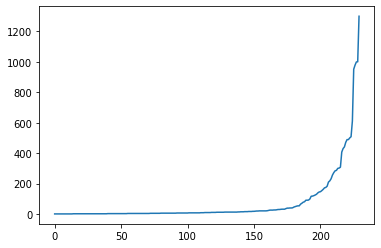

In [12]:
plt.plot({k: v for k, v in sorted(distinct_calls.items(), key=lambda item: item[1])}.values())

In [13]:
sort_vocab.values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,

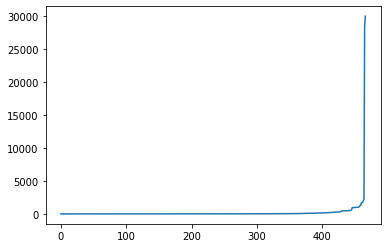

In [14]:
plt.plot(sort_vocab.values())

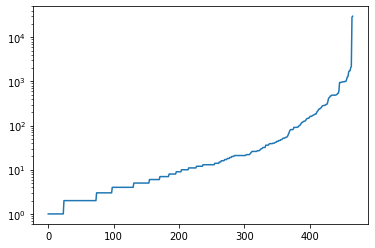

In [15]:
plt.semilogy(sort_vocab.values())#, title="Vocab frequency distribution (log scaled)")

In [16]:
with open("data_set.txt", "w") as out:
    out.writelines(string_traces)

In [17]:
len(string_traces)

29749

In [18]:
len(indexed_traces)

20

In [19]:
len(traces)

1165

In [22]:
from statistics import mean

## Do we have a useful Java-specific angle for the project?
We envision 2 usecases for this approach. Our approach captures the runtime behaviour of a piece of given Java code, and can therefore be used for:
* Clone detection: similar or identical pieces of code violate DRY principles. While state of the art NLM approaches such as CodeT5 do well, they lack understanding of runtime semantics.
* Code similarity calculation: Similar to the above task, our approach allows us to calculate how similar a given set of code is based on runtime behaviour. Our trace embedding approach allows us to cluster similar pieces of code in an n-dimensional space.

## What's the distribution of trace lengths i.e. calls? How long is the average trace? 

# todo: log scale version, 95th percentile
are reflect calls being made by junit internally i.e. before test case runs?
- stick to traces processable under 1hr each
- find the root of the trace
- more filtering (esp regarding junit)
- setup the model, train transformer
- is it meaningful to know how deep the call to java.util (eg) is?
- is stateformer useful for learning about program structure? eg how deep the call is
- diversity of data. revisit next week.
conf Automated SE end April

31.44485981308411

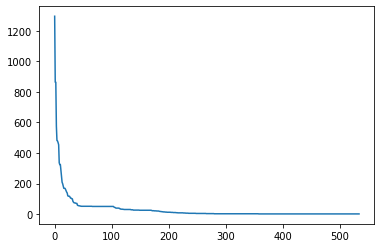

In [23]:
sorted_calls_per_trace = {k: v for k, v in sorted(calls_per_trace.items(), reverse=True, key=lambda item: item[1])}.values()
plt.plot(sorted_calls_per_trace)
mean(sorted_calls_per_trace)


## What's the distribution of distinct calls?

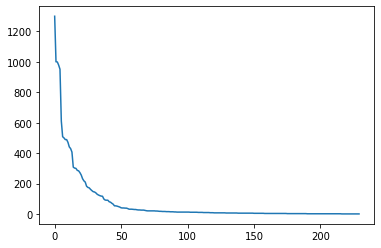

In [24]:
sorted_distinct = {k: v for k, v in sorted(distinct_calls.items(), reverse=True, key=lambda item: item[1])}.values()
plt.plot(sorted_distinct)


There are about 260 distinct calls (i.e. the exact FQN, arg types, and return types are identical). Exponential.

## What if we prune everything but the top 20%?

In [25]:
sum(list(sorted_distinct))

16823

In [26]:
sum(list(sorted_distinct))*0.2 # 20% of the mass is located in values less than

3364.6000000000004

In [27]:
sum(list(sorted_distinct)[:3])

3298

We see that the top-3 make up almost 20% of the values.

## How many invocations does the average test case (the whole class) in our dataset make?

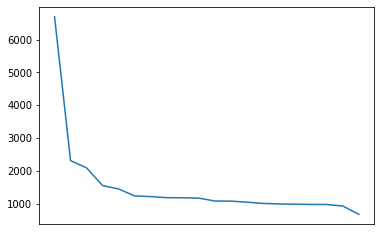

In [28]:
sorted_dumps_counter = {k: v for k, v in sorted(dump_counter.items(), reverse=True, key=lambda item: item[1])}.values()
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.plot(sorted_dumps_counter)

In [29]:

mean(sorted_dumps_counter)

1486.45

This graph represents the number of traces per test case, which is equal to the number of method invocations per test case. The average test case makes 1486 method invocations.

## How deep does the average trace go?
This is counted by incrementing a counter per test case/method FQN each time an indexed trace is called.

In [30]:
for k in calls_per_trace.keys():
    if not k in recursions_per_trace:
        recursions_per_trace[k] = 0

0.34205607476635513

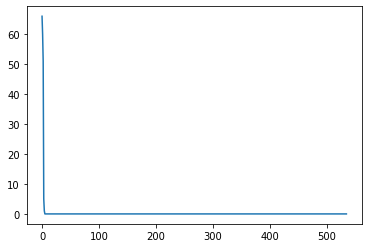

In [31]:
recursions_per_trace_counter = {k: v for k, v in sorted(recursions_per_trace.items(), reverse=True, key=lambda item: item[1])}.values()
ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
plt.plot(recursions_per_trace_counter)
from statistics import mean
mean(recursions_per_trace_counter)

The average trace has a very low depth. In fact, there are only 4 traced methods that refer to other traces i.e. are recursive. We believe this is due to the limited dev dataset.

## What is the namespace distribution of the calls?
How many are java.util, java.core etc

In [32]:
api_counter_sort = {k: v for k, v in sorted(api_counter.items(), reverse=True, key=lambda item: item[1])}
import itertools
api_counter_sorted = dict(itertools.islice(api_counter_sort.items(), 30))

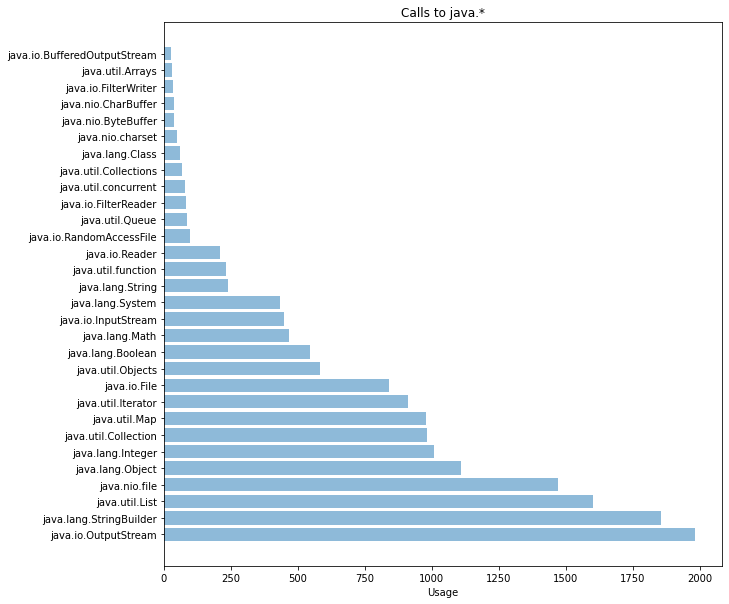

In [33]:
y_pos = range(0, len(api_counter_sorted))
fig = plt.figure(figsize=(10,10)) 
plt.barh(y_pos,api_counter_sorted.values(), align='center', alpha=0.5)
plt.yticks(y_pos, api_counter_sorted.keys())
plt.xlabel('Usage')
plt.title('Calls to java.*')

plt.show()

We see that the distribution quickly tapers off: the majority of calls to the java namespace are to a couple classes.

## Does it make sense to ignore traces with more than 100 calls or more than a depth of 100?
No, the majority of traces have well over 100 calls, and most are very shallow (<4).

## How many API calls are made along the way on average?
Given the very shallow depth of traces in this dataset, I have not analyzed the amount of calls along a recursive descent. Instead, I look at how many API calls are made per traced method.